# Setting up

In [1]:
import os
import numpy as np
import pandas as pd
import torch
import seaborn as sns
import string
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torch.nn.utils.rnn import pad_sequence
from torch.optim.lr_scheduler import StepLR
from IPython.display import FileLink
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/multilingual-hatespeech-dataset/Dataset/Training/MultiLanguageTrainDataset.csv
/kaggle/input/multilingual-hatespeech-dataset/Dataset/Testing/Test2/MangolianTranslatedHateSpeech.csv
/kaggle/input/multilingual-hatespeech-dataset/Dataset/Testing/Test2/IrishTranslatedHateSpeech.csv
/kaggle/input/multilingual-hatespeech-dataset/Dataset/Testing/Test2/HindiTranslatedHateSpeech.csv
/kaggle/input/multilingual-hatespeech-dataset/Dataset/Testing/Test2/PersianTranslatedHateSpeech.csv
/kaggle/input/multilingual-hatespeech-dataset/Dataset/Testing/Test2/UrduTranslatedHateSpeech.csv
/kaggle/input/multilingual-hatespeech-dataset/Dataset/Testing/Test2/GeorgianTranslatedHateSpeech.csv
/kaggle/input/multilingual-hatespeech-dataset/Dataset/Testing/TestEmbedded2/MangolianLASERWordEmbeddings.csv
/kaggle/input/multilingual-hatespeech-dataset/Dataset/Testing/TestEmbedded2/IrishLASERWordEmbeddings.csv
/kaggle/input/multilingual-hatespeech-dataset/Dataset/Testing/TestEmbedded2/GeorgianLASERWordEmbe

In [3]:
preprocessed_trainset = pd.read_pickle('/kaggle/input/back-translation/other/back_translation/1/preprocessed_back_translation_trainset.pkl')
preprocessed_valset = pd.read_pickle('/kaggle/input/back-translation/other/back_translation/1/preprocessed_back_translation_valset.pkl')
preprocessed_testset = pd.read_pickle('/kaggle/input/back-translation/other/back_translation/1/preprocessed_back_translation_testset.pkl')

In [4]:
preprocessed_trainset

,text,label,language,cleaned_text
0,@m__isis ...,0.0,2,[]
1,"'How ISIS Brainwashed Me', an American Young G...",0.0,2,"[isi, brainwash, american, young, girl, speaks]"
2,Muslim Man Hugs ISIS Militant Armed Wearing Su...,0.0,2,"[muslim, man, hug, isi, militant, arm, wear, s..."
3,Le grand absent de l'euro a aura t daesh,0.0,2,"[le, grand, absent, de, leuro, aura, daesh]"
4,RT @joej2020usa: Netanyahu: Paris Massacre Sho...,1.0,2,"[netanyahu, paris, massacre, show, radical, is..."
...,...,...,...,...
56306,"PENGGUNA Sampaoli adalah sontoloyo, lebih memi...",1.0,13,"[guna, sampaol, sontoloyo, pilih, higuain, icard]"
56307,USER USER USER USER USER USER USER USER USER U...,1.0,13,"[eh, serius, pengin, muntah, banget, tahi, lo,..."
56308,Pengguna,1.0,13,[guna]
56309,OTAK KACANG.. DIKTATOR JOKOWI ADALAH TIKET HEB...,1.0,13,"[otak, kacang, ktator, jokow, tiket, hebat, ja..."


In [5]:
preprocessed_valset

,text,label,language,cleaned_text
0,Massive explosion rocked Sadr city east #Baghd...,1.0,2,"[massive, explosion, rock, sadr, city, east, b..."
1,@user @user @user well didnt pay 1000$ phone 1...,1.0,2,"[well, didnt, pay, phone, st, world, mongoloid]"
2,RT @_______Krista: Vous n'avez pas peur de Die...,0.0,2,"[vous, navez, pas, peur, de, dieu, mais, vous,..."
3,RT @Nidalgazaui: Dozens of Shiite Hasd-Al-Shab...,1.0,2,"[dozen, shiite, hasdalshab, leader, kill, diya..."
4,@user see ferocity flames twat. indentificatio...,0.0,2,"[see, ferocity, flame, twat, indentification, ..."
...,...,...,...,...
21915,USER Gapapa sipit juga cantik aku mah \xf0\x9f...,0.0,13,"[gapapa, sipit, cantik, mah]"
21916,Koalisi tapi pakai hati. Cuci tangan sambil be...,0.0,13,"[koalisi, paka, hati, cuci, tangan, gandeng, t..."
21917,USER ke jamban ?',0.0,13,[jamban]
21918,USER Ngga ada kucing yang kesurupan karena kuc...,1.0,13,"[kucing, surup, kucing, setan]"


In [6]:
preprocessed_testset

,text,label,language,cleaned_text
0,RT @warreports: 8 Pakistanis of #IRGC 's Zeyna...,1.0,2,"[pakistani, irgc, zeynabiun, brigade, kill, no..."
1,gronk tide pod commercial retarded,1.0,2,"[gronk, tide, pod, commercial, retard]"
2,@sfrantzman @pmakela1 what they found in Syria...,0.0,2,"[find, syria, lot, weapon, wwii, gun, shop, is..."
3,After Pakistani Taliban announcement of their ...,0.0,2,"[pakistani, taliban, announcement, support, is..."
4,Good luck getting our attention this week ISIS...,0.0,2,"[good, luck, get, attention, week, isi, pokemo..."
...,...,...,...,...
8115,"Ajarkan Muslim, agama tak ngajarkan membunuh, ...",1.0,13,"[ajar, muslim, agama, ngajar, bunuh, paham, is..."
8116,"RT USER: Mainstream sdh jelas,bhw oposisi meng...",0.0,13,"[mainstream, jelasbhw, oposisi, esan, neger, m..."
8117,"Bismillah,; superiorPRINTING;; Harga; Ecer :LG...",0.0,13,"[bismil, superiorprinting, harga, ecer, lgnpol..."
8118,Nama Lengkap : Iris Jung\n\nNama Asli : Jung A...,0.0,13,"[nama, lengkap, iris, jungnnnama, asli, jung, ..."


# Word2vec Embedding

In [7]:
from gensim.models import Word2Vec
def train_word2vec_model(dataframe):
    """
    Train a Word2Vec model on sentences from the provided DataFrame and apply the model
    to get embeddings for each sentence.
    """
    
    tokenized_sentences = dataframe['cleaned_text'].tolist()

    # Train the Word2Vec model
    word2vec_model = Word2Vec(tokenized_sentences, vector_size=300, window=5, min_count=1, workers=4)

    return word2vec_model

  
# Define a function to get the vector for a list of tokens or return zeros if not found
def get_word_vectors(word2vec_model, tokens):
    vocabulary = word2vec_model.wv.index_to_key
    return np.array([word2vec_model.wv[word] if word in vocabulary else [0] * word2vec_model.vector_size for word in tokens])

In [8]:
def word_embeddings(dataframe, model):

    dataframe['embeddings'] = dataframe['cleaned_text'].apply(lambda x: get_word_vectors(model, x))
    
    return dataframe

## Embedded Trainset

In [9]:
embedding_model = train_word2vec_model(preprocessed_trainset)
embedded_trainset = word_embeddings(preprocessed_trainset, embedding_model)
embedded_trainset

,text,label,language,cleaned_text,embeddings
0,@m__isis ...,0.0,2,[],[]
1,"'How ISIS Brainwashed Me', an American Young G...",0.0,2,"[isi, brainwash, american, young, girl, speaks]","[[-0.19392562, 0.77091825, 0.18682678, 0.66190..."
2,Muslim Man Hugs ISIS Militant Armed Wearing Su...,0.0,2,"[muslim, man, hug, isi, militant, arm, wear, s...","[[0.5845087, 1.2373981, 0.21791333, 0.86442226..."
3,Le grand absent de l'euro a aura t daesh,0.0,2,"[le, grand, absent, de, leuro, aura, daesh]","[[-0.27350053, -0.080847524, 1.4313946, 0.4205..."
4,RT @joej2020usa: Netanyahu: Paris Massacre Sho...,1.0,2,"[netanyahu, paris, massacre, show, radical, is...","[[0.021905629, 0.044617493, 0.016702048, 0.026..."
...,...,...,...,...,...
56306,"PENGGUNA Sampaoli adalah sontoloyo, lebih memi...",1.0,13,"[guna, sampaol, sontoloyo, pilih, higuain, icard]","[[0.0637022, 0.3732965, 0.58146006, 0.5668859,..."
56307,USER USER USER USER USER USER USER USER USER U...,1.0,13,"[eh, serius, pengin, muntah, banget, tahi, lo,...","[[0.023873677, 0.17507046, 0.3867318, 0.339364..."
56308,Pengguna,1.0,13,[guna],"[[0.0637022, 0.3732965, 0.58146006, 0.5668859,..."
56309,OTAK KACANG.. DIKTATOR JOKOWI ADALAH TIKET HEB...,1.0,13,"[otak, kacang, ktator, jokow, tiket, hebat, ja...","[[-0.020988476, 0.20066723, 0.48877805, 0.4543..."


## Embedded Validation Set

In [10]:
embedded_valset = word_embeddings(preprocessed_valset, embedding_model)
embedded_valset

,text,label,language,cleaned_text,embeddings
0,Massive explosion rocked Sadr city east #Baghd...,1.0,2,"[massive, explosion, rock, sadr, city, east, b...","[[0.0938897505402565, 0.39030513167381287, 0.1..."
1,@user @user @user well didnt pay 1000$ phone 1...,1.0,2,"[well, didnt, pay, phone, st, world, mongoloid]","[[0.12665205, 0.68771255, 0.15845914, 0.651728..."
2,RT @_______Krista: Vous n'avez pas peur de Die...,0.0,2,"[vous, navez, pas, peur, de, dieu, mais, vous,...","[[-0.09718643873929977, -0.09955067932605743, ..."
3,RT @Nidalgazaui: Dozens of Shiite Hasd-Al-Shab...,1.0,2,"[dozen, shiite, hasdalshab, leader, kill, diya...","[[0.053369276225566864, 0.3856620490550995, 0...."
4,@user see ferocity flames twat. indentificatio...,0.0,2,"[see, ferocity, flame, twat, indentification, ...","[[0.27461060881614685, 0.9410380125045776, 0.0..."
...,...,...,...,...,...
21915,USER Gapapa sipit juga cantik aku mah \xf0\x9f...,0.0,13,"[gapapa, sipit, cantik, mah]","[[0.01644854, 0.028501844, 0.07767333, 0.04887..."
21916,Koalisi tapi pakai hati. Cuci tangan sambil be...,0.0,13,"[koalisi, paka, hati, cuci, tangan, gandeng, t...","[[0.029706047847867012, 0.04962030053138733, 0..."
21917,USER ke jamban ?',0.0,13,[jamban],"[[0.03143225, 0.09443111, 0.18398087, 0.153749..."
21918,USER Ngga ada kucing yang kesurupan karena kuc...,1.0,13,"[kucing, surup, kucing, setan]","[[0.032012325, 0.089555405, 0.17523238, 0.1408..."


## Embedded Testset

In [11]:
embedded_testset = word_embeddings(preprocessed_testset, embedding_model)
embedded_testset

,text,label,language,cleaned_text,embeddings
0,RT @warreports: 8 Pakistanis of #IRGC 's Zeyna...,1.0,2,"[pakistani, irgc, zeynabiun, brigade, kill, no...","[[0.054055146872997284, 0.1521911323070526, 0...."
1,gronk tide pod commercial retarded,1.0,2,"[gronk, tide, pod, commercial, retard]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,@sfrantzman @pmakela1 what they found in Syria...,0.0,2,"[find, syria, lot, weapon, wwii, gun, shop, is...","[[0.07498982, 0.66788507, 0.22955482, 0.522269..."
3,After Pakistani Taliban announcement of their ...,0.0,2,"[pakistani, taliban, announcement, support, is...","[[0.054055146872997284, 0.1521911323070526, 0...."
4,Good luck getting our attention this week ISIS...,0.0,2,"[good, luck, get, attention, week, isi, pokemo...","[[0.0400138, 0.5730819, 0.17764494, 0.63788384..."
...,...,...,...,...,...
8115,"Ajarkan Muslim, agama tak ngajarkan membunuh, ...",1.0,13,"[ajar, muslim, agama, ngajar, bunuh, paham, is...","[[0.038950924, 0.15747035, 0.41411304, 0.50734..."
8116,"RT USER: Mainstream sdh jelas,bhw oposisi meng...",0.0,13,"[mainstream, jelasbhw, oposisi, esan, neger, m...","[[0.03416469693183899, 0.060510482639074326, 0..."
8117,"Bismillah,; superiorPRINTING;; Harga; Ecer :LG...",0.0,13,"[bismil, superiorprinting, harga, ecer, lgnpol...","[[0.0034209415316581726, 0.016556918621063232,..."
8118,Nama Lengkap : Iris Jung\n\nNama Asli : Jung A...,0.0,13,"[nama, lengkap, iris, jungnnnama, asli, jung, ...","[[-0.0010630625765770674, 0.18249447643756866,..."


# Training BiLSTM


#### Batch the data

In [12]:
class EmbeddingDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe[dataframe['embeddings'].str.len() > 0]

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        embeddings = [torch.tensor(np.array(e, dtype=np.float32)) for e in row['embeddings'] if len(e) > 0]
        embeddings = torch.stack(embeddings) if embeddings else torch.empty((0, len(row['embeddings'][0])))
        label = torch.tensor(row['label'], dtype=torch.float32)
        return embeddings, label

In [13]:
def create_tensor_dataset(dataframe):
    """
    Converts a DataFrame with embeddings and labels into a PyTorch TensorDataset.
    """
    # Filter the DataFrame to ensure only valid entries are processed
    valid_entries = dataframe[dataframe['embeddings'].str.len() > 0]
    
    # Create a custom dataset from the filtered DataFrame
    custom_dataset = EmbeddingDataset(valid_entries)
    
    # Collect all embeddings and labels
    embeddings_list = []
    labels_list = []
    
    for embeddings, label in custom_dataset:
        embeddings_list.append(embeddings)
        labels_list.append(label)
    
    # Pad the embeddings to have uniform length
    embeddings_tensor = pad_sequence(embeddings_list, batch_first=True, padding_value=0.0)
    
    # Stack labels into a tensor
    labels_tensor = torch.stack(labels_list)
    
    # Create and return a TensorDataset
    final_dataset = TensorDataset(embeddings_tensor, labels_tensor)
    
    return final_dataset

In [14]:
training_dataset = create_tensor_dataset(embedded_trainset)
validation_dataset = create_tensor_dataset(embedded_valset)
testing_dataset = create_tensor_dataset(embedded_testset)

In [15]:
# en_dataset_train = create_tensor_dataset(embedded_trainset[embedded_trainset.language==3])

In [16]:
# # Calculate the lengths of each subset
# total_size = len(en_dataset_train)
# train_size = int(0.6 * total_size)
# val_size = int(0.3 * total_size)
# test_size = total_size - train_size - val_size  # Ensure all data is used

# # Split the dataset
# training_dataset, validation_dataset, testing_dataset = random_split(en_dataset_train, [train_size, val_size, test_size])

In [17]:
batch_size = 64
# Define batch size for loaders
train_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(testing_dataset, batch_size=batch_size, shuffle=False) 

In [18]:
# class SimpleBiLSTM(nn.Module):
#     def __init__(self, embedding_dim, hidden_dim,num_layers,batch_first,bidirectional):
#         super(SimpleBiLSTM, self).__init__()
#         # Define a bidirectional LSTM
#         self.lstm = nn.LSTM(input_size=embedding_dim, 
#                             hidden_size=hidden_dim, 
#                             num_layers=num_layers,
#                             batch_first=batch_first, 
#                             bidirectional=bidirectional)
        
#         # Define a fully connected layer to map the concatenated hidden states to a single output
#         self.fc = nn.Linear(in_features=2 * hidden_dim, out_features=1)

#     def forward(self, x):
#         # Forward pass through LSTM layer
#         _, (hn, _) = self.lstm(x)  # hn contains the hidden state for each direction of each layer
        
#         # Concatenate the last hidden states of the forward and backward passes from the last layer
#         hn_cat = torch.cat((hn[-2], hn[-1]), dim=1)

#         # Pass the concatenated hidden states through the fully connected layer and apply sigmoid activation
#         out = self.fc(hn_cat)
#         out = torch.sigmoid(out)

#         # Squeeze the output to remove the singleton dimension to match expected output shape (batch_size,)
#         return out.squeeze(1)

In [19]:
class SimpleBiLSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, num_layers, batch_first, bidirectional, dropout_rate=0.5):
        super(SimpleBiLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=embedding_dim, 
                            hidden_size=hidden_dim, 
                            num_layers=num_layers,
                            batch_first=batch_first, 
                            bidirectional=bidirectional,
                            dropout=dropout_rate if num_layers > 1 else 0)  # Apply dropout only if there are multiple layers
        
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(in_features=2 * hidden_dim, out_features=1)

    def forward(self, x):

        _, (hn, _) = self.lstm(x) 
        
        hn_cat = torch.cat((hn[-2], hn[-1]), dim=1)

        hn_cat = self.dropout(hn_cat)

        out = self.fc(hn_cat)
        out = torch.sigmoid(out)

        return out.squeeze(1)

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming model instantiation and optimizer setup as before
model = SimpleBiLSTM(embedding_dim=300, hidden_dim=128, num_layers=2, batch_first=True, bidirectional=True)
num_epochs = 15
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
patience = 2
delta = 0.001

# Print the summary of the model
summary(model, input_size=(64, 256, 300))

Layer (type:depth-idx)                   Output Shape              Param #
SimpleBiLSTM                             [64]                      --
├─LSTM: 1-1                              [64, 256, 256]            835,584
├─Dropout: 1-2                           [64, 256]                 --
├─Linear: 1-3                            [64, 1]                   257
Total params: 835,841
Trainable params: 835,841
Non-trainable params: 0
Total mult-adds (G): 13.69
Input size (MB): 19.66
Forward/backward pass size (MB): 33.55
Params size (MB): 3.34
Estimated Total Size (MB): 56.56

In [21]:
def validate_model(model, epoch, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} (Val)'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels.float())
            total_loss += loss.item()
            predicted = (outputs > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / len(val_loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

In [22]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, scheduler, device, patience, delta, save_path):
    
    model.to(device)
    
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    best_val_loss = float('inf')
    early_stopping_counter = 0  # Initialize the counter for early stopping

    for epoch in range(num_epochs):
        model.train()
        total_loss, total, correct = 0, 0, 0

        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} (Train)'):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_avg_loss = total_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_avg_loss)
        train_accuracies.append(train_accuracy)

        val_avg_loss, val_accuracy = validate_model(model, epoch, val_loader, criterion, device)
        val_losses.append(val_avg_loss)
        val_accuracies.append(val_accuracy)
        
        print(f'End of Epoch {epoch+1}, Train Loss: {train_avg_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_avg_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')
        
        if val_avg_loss < best_val_loss - delta:
            best_val_loss = val_avg_loss
            early_stopping_counter = 0
            torch.save(model.state_dict(), save_path)
            print(f'Model saved: Epoch {epoch+1} with Val Loss: {val_avg_loss:.4f}')
        else:
            early_stopping_counter += 1
            print(f'No improvement in Val Loss for {early_stopping_counter} epoch(s)')

        if early_stopping_counter >= patience:
            print(f'Early stopping triggered after {epoch+1} epochs')
            break

        scheduler.step()

    return train_losses, train_accuracies, val_losses, val_accuracies

In [23]:
# Assume you have run your training function already
train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, scheduler, device, patience, delta, save_path='BiLSTM_back_translate.pth')

Epoch 1/15 (Val): 100%|██████████| 336/336 [00:06<00:00, 55.44it/s]


End of Epoch 1, Train Loss: 0.4815, Train Accuracy: 75.40%, Val Loss: 0.4372, Val Accuracy: 77.80%
Model saved: Epoch 1 with Val Loss: 0.4372


Epoch 2/15 (Val): 100%|██████████| 336/336 [00:06<00:00, 54.84it/s]


End of Epoch 2, Train Loss: 0.4358, Train Accuracy: 78.70%, Val Loss: 0.4099, Val Accuracy: 80.18%
Model saved: Epoch 2 with Val Loss: 0.4099


Epoch 3/15 (Val): 100%|██████████| 336/336 [00:06<00:00, 54.63it/s]


End of Epoch 3, Train Loss: 0.4224, Train Accuracy: 80.05%, Val Loss: 0.3881, Val Accuracy: 81.60%
Model saved: Epoch 3 with Val Loss: 0.3881


Epoch 4/15 (Val): 100%|██████████| 336/336 [00:06<00:00, 55.00it/s]


End of Epoch 4, Train Loss: 0.4042, Train Accuracy: 81.21%, Val Loss: 0.3773, Val Accuracy: 83.03%
Model saved: Epoch 4 with Val Loss: 0.3773


Epoch 5/15 (Val): 100%|██████████| 336/336 [00:06<00:00, 55.15it/s]


End of Epoch 5, Train Loss: 0.3960, Train Accuracy: 81.65%, Val Loss: 0.3816, Val Accuracy: 82.44%
No improvement in Val Loss for 1 epoch(s)


Epoch 6/15 (Val): 100%|██████████| 336/336 [00:06<00:00, 54.85it/s]


End of Epoch 6, Train Loss: 0.3757, Train Accuracy: 82.91%, Val Loss: 0.3739, Val Accuracy: 82.95%
Model saved: Epoch 6 with Val Loss: 0.3739


Epoch 7/15 (Val): 100%|██████████| 336/336 [00:06<00:00, 54.81it/s]


End of Epoch 7, Train Loss: 0.3720, Train Accuracy: 83.24%, Val Loss: 0.3659, Val Accuracy: 83.36%
Model saved: Epoch 7 with Val Loss: 0.3659


Epoch 8/15 (Val): 100%|██████████| 336/336 [00:06<00:00, 55.26it/s]


End of Epoch 8, Train Loss: 0.3682, Train Accuracy: 83.36%, Val Loss: 0.3706, Val Accuracy: 83.25%
No improvement in Val Loss for 1 epoch(s)


Epoch 9/15 (Val): 100%|██████████| 336/336 [00:06<00:00, 55.62it/s]


End of Epoch 9, Train Loss: 0.3663, Train Accuracy: 83.48%, Val Loss: 0.3630, Val Accuracy: 83.71%
Model saved: Epoch 9 with Val Loss: 0.3630


Epoch 10/15 (Val): 100%|██████████| 336/336 [00:06<00:00, 54.91it/s]


End of Epoch 10, Train Loss: 0.3647, Train Accuracy: 83.60%, Val Loss: 0.3641, Val Accuracy: 83.50%
No improvement in Val Loss for 1 epoch(s)


Epoch 11/15 (Val): 100%|██████████| 336/336 [00:06<00:00, 54.87it/s]

End of Epoch 11, Train Loss: 0.3617, Train Accuracy: 83.79%, Val Loss: 0.3634, Val Accuracy: 83.69%
No improvement in Val Loss for 2 epoch(s)
Early stopping triggered after 11 epochs


In [24]:
# model file link
FileLink(r'BiLSTM_back_translate.pth')

/kaggle/working/BiLSTM_back_translate.pth

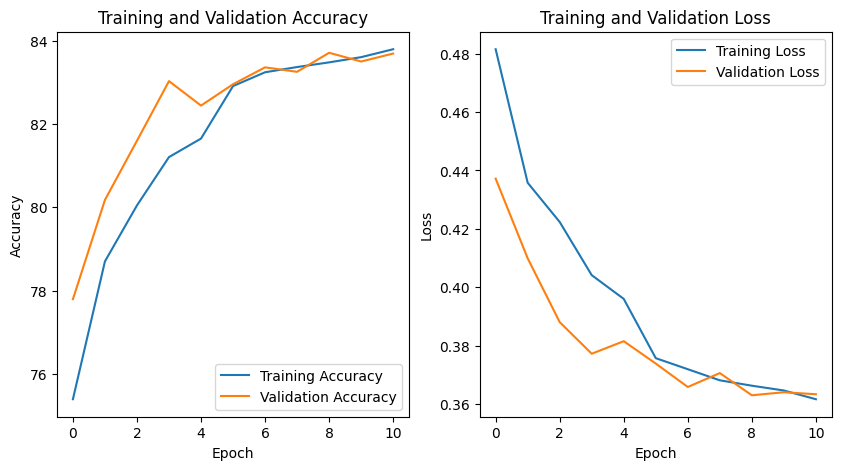

In [25]:
# Plotting
plt.figure(figsize=(10, 5))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [26]:
def evaluate_model(model, dataloader, device):
    model.to(device)
    model.eval()

    all_labels = []
    all_predictions = []
    all_probs = []  # To store probabilities for ROC curve computation

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probabilities = outputs.squeeze()  # Assuming the model outputs probabilities for positive class
            predictions = (probabilities > 0.5).float()  # Convert probabilities to 0 or 1 based on threshold

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())
            all_probs.extend(probabilities.cpu().numpy())

    # Convert list to numpy arrays for metric calculations
    all_labels = np.array(all_labels)
    all_predictions = np.array(all_predictions)
    all_probs = np.array(all_probs)

    # Calculate standard metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, zero_division=0)
    recall = recall_score(all_labels, all_predictions, zero_division=0)
    f1 = f1_score(all_labels, all_predictions, zero_division=0)

    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_predictions)

    # Generate and print the classification report
    report = classification_report(all_labels, all_predictions, zero_division=0)

    # Compute ROC curve and ROC area for each class
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    # Print the overall metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("\nClassification Report:\n", report)

    return accuracy, precision, recall, f1, report, conf_matrix, fpr, tpr, roc_auc

In [27]:
model_eval = SimpleBiLSTM(embedding_dim=300, hidden_dim=128, num_layers=2, batch_first=True, bidirectional=True)

# Load the state dictionary
model_eval.load_state_dict(torch.load('BiLSTM_back_translate.pth'))

accuracy, precision, recall, f1, report, conf_matrix, fpr, tpr, roc_auc = evaluate_model(model, test_loader, device)

Evaluating: 100%|██████████| 125/125 [00:02<00:00, 59.76it/s]


Accuracy: 0.8331
Precision: 0.7785
Recall: 0.8579
F1 Score: 0.8163

Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.81      0.85      4513
         1.0       0.78      0.86      0.82      3434

    accuracy                           0.83      7947
   macro avg       0.83      0.84      0.83      7947
weighted avg       0.84      0.83      0.83      7947



# Confusion Matrix

In [28]:
def plot_confusion_matrix(conf_matrix, class_labels):
    """
    Plots a confusion matrix using seaborn's heatmap with percentages and TP, TN, FP, FN annotations.
    """
    # Calculate the percentage of each confusion entry
    conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

    # Create annotations that include both count and percentage, and classification (TP, TN, FP, FN)
    annotations = np.empty_like(conf_matrix).astype(str)
    nrows, ncols = conf_matrix.shape
    for i in range(nrows):
        for j in range(ncols):
            c = conf_matrix[i, j]
            p = conf_matrix_percent[i, j] * 100
            if i == 0 and j == 0:
                label = "TN"
            elif i == 0 and j == 1:
                label = "FP"
            elif i == 1 and j == 0:
                label = "FN"
            elif i == 1 and j == 1:
                label = "TP"
            annotations[i, j] = f"{label}\n{c}\n({p:.1f}%)"

    # Plotting
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=annotations, fmt='', cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

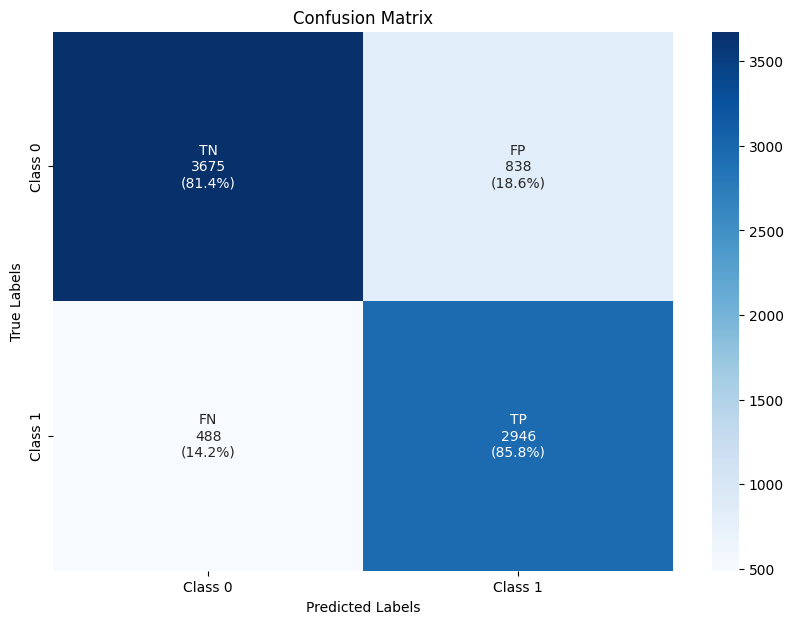

In [29]:
plot_confusion_matrix(conf_matrix, class_labels=['Class 0', 'Class 1'])

# ROC Curve

In [30]:
def plot_roc_curve(fpr, tpr, roc_auc):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

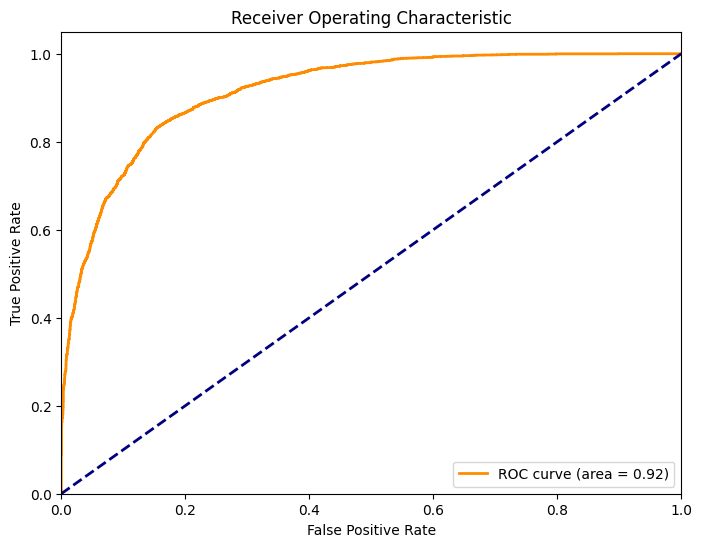

In [31]:
plot_roc_curve(fpr, tpr, roc_auc)

In [32]:
# import pickle
# pickle.dump(model, open('BiLSTM_model.pkl', 'wb'))